# Prepoznavanje saobraćajnih znakova (Traffic Sign Recognition)

In [1]:
import torch
from torch import nn, optim, cuda
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import os
import csv
import random

## Skup podataka (Dataset)

Izabrani skup podataka za obradu je skup nemačkih saobraćajnih znakova pod nazivom **GTSRB - German Traffic Sign Recognition Benchmark**.

Podaci su javno dostupni i preuzeti sa web stranice *Kaggle*.

Cilj obrade podataka je obučavanje modela za klasifikaciju jednog saobraćajnog znaka prikazanog na slici. 

Skup podataka sadrži više od 50.000 slika, koje predstavljaju 43 klase saobraćajnih znakova.

In [2]:
class TrafficSignDataset(Dataset):
    def __init__(self, dir, file, transform):
        super().__init__()

        self.features = []
        self.labels = []

        self.dir = dir
        self.transform = transform
        self._read(os.path.join(dir, file))

    def _read(self, path):
        with open(path) as file:
            csv_reader = csv.reader(file)
            next(csv_reader)
            for row in csv_reader:
                self.features.append(self._load_image(row[7]))
                self.labels.append(int(row[6]))

    def _load_image(self, path):
        return self.transform(Image.open(os.path.join(self.dir, path)))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return (self.features[index], self.labels[index])

### Pripremna obrada podataka

Nad svakom slikom primenjene su sledeće transformacije:

- Veličina svake slike je podešena na 32x32 piksela
- Svaka slika je konvertovana u tenzor

S obzirom da su podaci u skupu već podeljeni na trening i test skup, to nije bilo potrebno ručno raditi. 

Iz treninga skupa je izdvojeno je 20% podataka za skup za validaciju koji se koristi tokom treniranja da bi se dobila evaluacija modela i za eventualna podešavanja hiperparametara.

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset_dir = "dataset"

dataset = TrafficSignDataset(dataset_dir, "Train.csv", transform)

valid_dataset_length = int(len(dataset) * 0.2)
train_dataset, valid_dataset = random_split(dataset, [len(dataset) - valid_dataset_length, valid_dataset_length])

test_dataset = TrafficSignDataset(dataset_dir, "Test.csv", transform)

### Informacije o broju uzoraka i klasa

In [4]:
classes = len(set(test_dataset.labels))
total_examples = len(train_dataset) + len(valid_dataset) + len(test_dataset)

print(f"Ukupan broj uzoraka = {total_examples}")
print(f"Broj uzoraka za trening = {len(train_dataset)} ({len(train_dataset)/total_examples*100:.2f}%)")
print(f"Broj uzoraka za validaciju = {len(valid_dataset)} ({len(valid_dataset)/total_examples*100:.2f}%)")
print(f"Broj uzoraka za testiranje = {len(test_dataset)} ({len(test_dataset)/total_examples*100:.2f}%)")
print(f"Broj klasa = {classes}")

Ukupan broj uzoraka = 51839
Broj uzoraka za trening = 31368 (60.51%)
Broj uzoraka za validaciju = 7841 (15.13%)
Broj uzoraka za testiranje = 12630 (24.36%)
Broj klasa = 43


### Nasumični predstavnici svih klasa u skupu podataka

Kao što se može videti iz primera klasa, skup podataka je izazovan iz razloga sto je veliki broj slika mutan, a neke slike su ili previše ili nedovoljno osvetljene.

In [5]:
class_names = []
with open(os.path.join(dataset_dir, "Classes.csv"), "r") as f:
    csv_reader = csv.reader(f)
    next(csv_reader)
    for row in csv_reader:
        class_names.append(row[1])

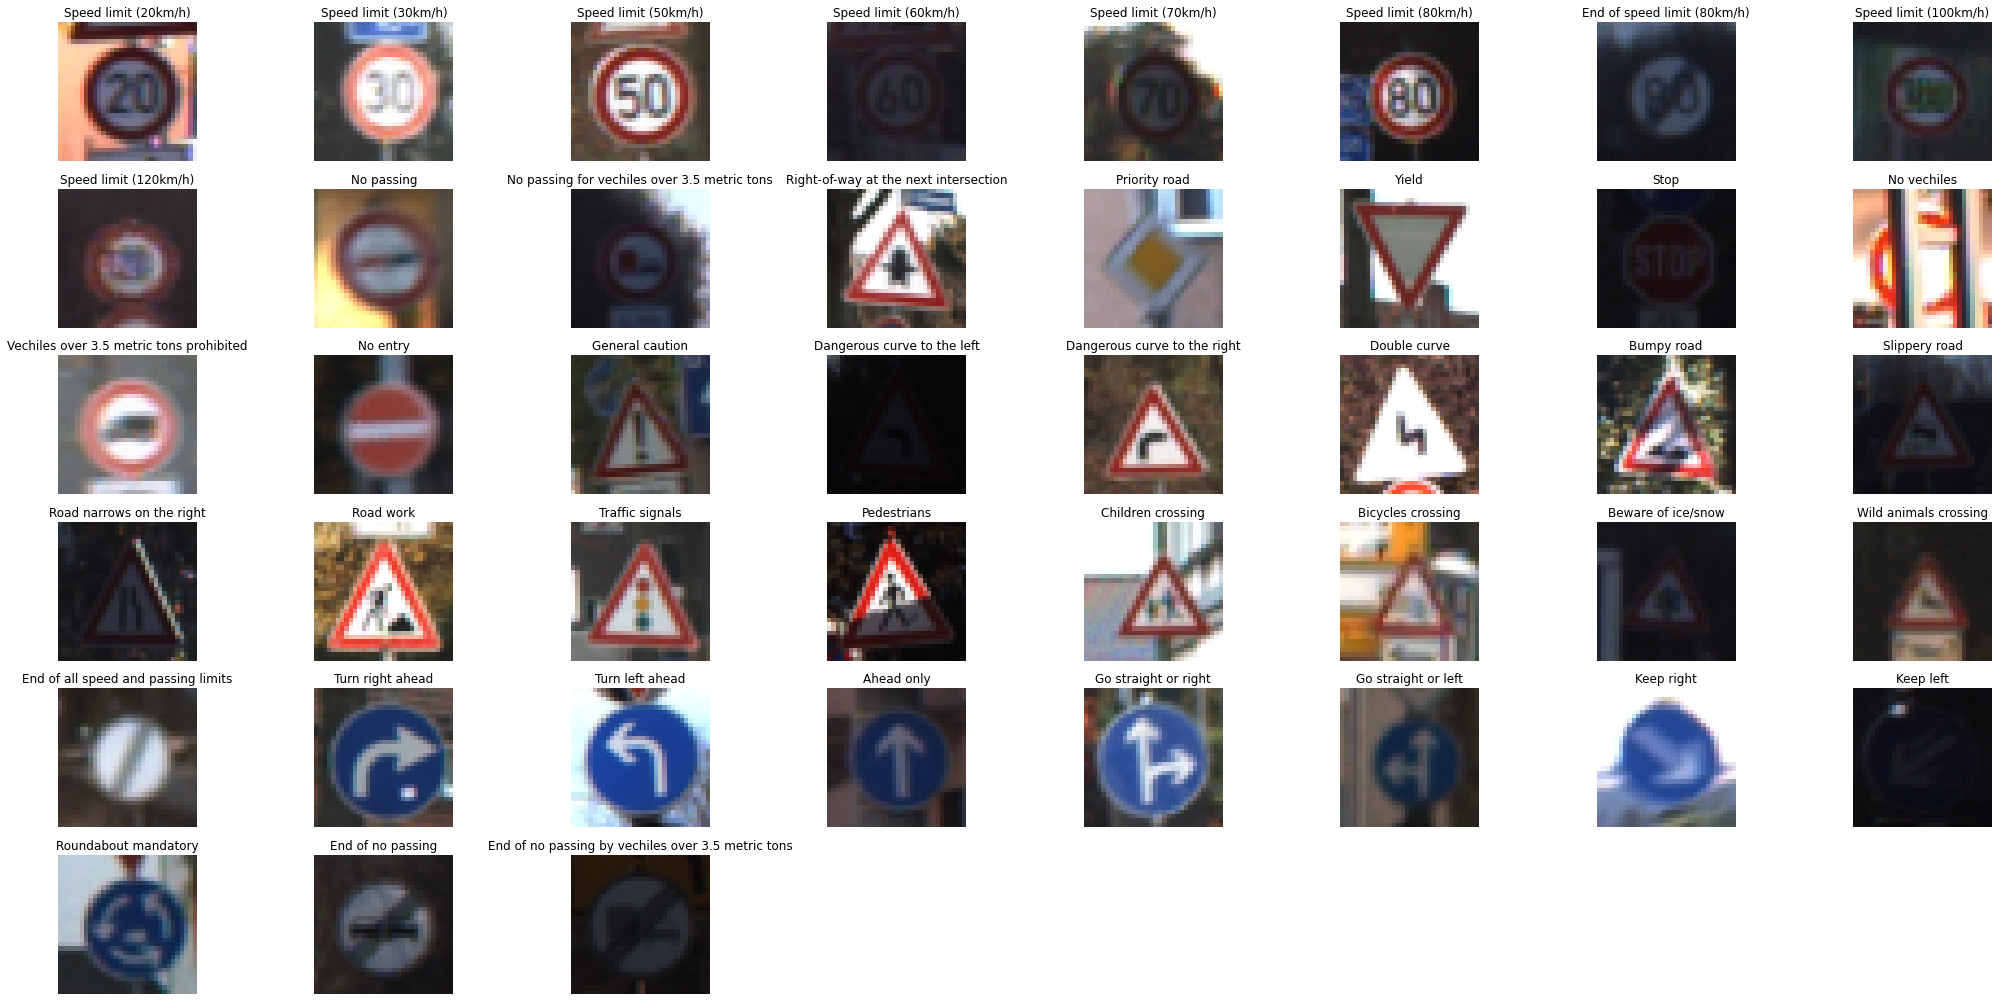

In [6]:
plt.figure(figsize=(36, 24))
labels = np.array(test_dataset.labels)

for c, class_name in enumerate(class_names):
    i = random.choice(np.where(labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis("off")
    plt.title(class_name)
    plt.imshow(np.transpose(test_dataset[i][0], (1, 2, 0)))

## Određivanje hardvera za računanja

Ukoliko je CUDA dostupan, koristiće se GPU, u suprotnom koristi se CPU.

In [7]:
if cuda.is_available():
    device = torch.device("cuda")
    cuda.empty_cache()
else:
    device = torch.device("cpu")

print(f"Hardver koji ce se upotrebljivati = {device}")

def to_device(x, y):
    return x.to(device), y.to(device)

Hardver koji ce se upotrebljivati = cuda


In [8]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [9]:
train_dl = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device) 
valid_dl = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device) 
test_dl = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Veštačke neuronske mreže (Artificial Neural Networks)

Definisanje funkcija za treniranje i testiranje.

In [10]:
def evaluate(model, loss_func, dl):
    loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for d in dl:
            fv, y = d
            yp = model.forward(fv)
            loss += loss_func(yp, y)
            max_index = torch.argmax(yp, dim=1)
            total += yp.size(0)
            correct += (y == max_index).sum().item()

    return loss/len(dl), correct/total

In [11]:
def train(epochs, model, loss_func, optimizer, train_dl, valid_dl):
    for epoch in range(epochs):
        total_train_loss = 0

        for d in train_dl:
            fv, y = d
            optimizer.zero_grad()
            yp = model.forward(fv)
            loss = loss_func(yp, y)
            loss.backward()
            total_train_loss += loss
            optimizer.step()
        
        validation_loss, validation_accuracy = evaluate(model, loss_func, valid_dl)
        print(f"[Epoch {epoch+1}/{epochs}] Train loss: {total_train_loss / len(train_dl):.2f}\t"
                f"Validation loss: {validation_loss:.2f}\tValidation accuracy: {validation_accuracy * 100:.2f}%")

In [12]:
def test(model, loss_func, test_dl):
    test_loss, test_accuracy = evaluate(model, loss_func, test_dl)
    print(f"Test loss: {test_loss:.2f}\tTest accuracy: {test_accuracy * 100:.2f}%")

## Višeslojni perceptron (Multilayer Perceptron)

Višeslojni perceptron (MLP) je vrsta feedforward veštacke neuronske mreže (ANN). 

Sam termin MLP se koristi dvosmisleno, ponekad za označavanje bilo koje feedforward veštačke neuronske mreže, a ponekad striktno na mreže sastavljene od više slojeva perceptrona.

MLP se ponekad nazivaju "vanila" neuronskim mrežama, posebno kada imaju samo jedan skriveni sloj.

Višešlojni perceptron se sastoji iz najmanje tri sloja neurona: ulaznog, skrivenog i izlaznog.

Svaki neuron ima nelinearnu aktivacionu funkciju, a u ovom primeru je upotrebljena ReLU funkcija koja je predstavljena jednačinom $f(x)=max(0,x)$.

In [13]:
class MLP(nn.Module):
    def __init__(self, classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 80)
        self.fc4 = nn.Linear(80, classes)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model ima {count_parameters(MLP(classes))} parametara koji mogu da se treniraju")

Model ima 392423 parametara koji mogu da se treniraju


### Gubitak unakrsne entropije (Cross-Entropy Loss)

Gubitak unakrsne entropije određuje perfomanse modela za klasifikaciju čiji su izlazi vrednosti verovatnoće između 0 i 1.

Ova vrednost se povećava kada predviđena verovatnoća divergira od stvarne labele.

U slučaju PyTorch biblioteke, klasa CrossEntropyLoss očekuje sirove podatke, to jest ne treba ih propustiti kroz softmax funkciju, jer ona interno primenjuje softmax.

### Upotreba Adam (Adaptive Moment Estimation) algoritma za optimizaciju

Jedan od najpopularnijih i najčešće upotrebljavanih algoritama za mašinsko učenje je upravo SGD, i on ima brojna proširenja i varijacije.

Adam algoritam je proširenje SGD algoritma, to jest kombinacija RMSProp (Root Mean Squared Propagation) i SGD sa momentumom.

U poslednje vreme ovaj algoritam ima veliku primenu u dubokom učenju za kompjutersku viziju i obradu prirodnih jezika.

In [15]:
mlp = MLP(classes).to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
epochs = 20

In [16]:
train(epochs, mlp, loss_function, optimizer, train_dl, valid_dl)
test(mlp, loss_function, test_dl)

[Epoch 1/20] Train loss: 2.27	Validation loss: 1.41	Validation accuracy: 59.04%
[Epoch 2/20] Train loss: 1.12	Validation loss: 0.90	Validation accuracy: 74.16%
[Epoch 3/20] Train loss: 0.83	Validation loss: 0.81	Validation accuracy: 76.29%
[Epoch 4/20] Train loss: 0.68	Validation loss: 0.89	Validation accuracy: 73.94%
[Epoch 5/20] Train loss: 0.59	Validation loss: 0.58	Validation accuracy: 83.68%
[Epoch 6/20] Train loss: 0.52	Validation loss: 0.48	Validation accuracy: 86.60%
[Epoch 7/20] Train loss: 0.46	Validation loss: 0.61	Validation accuracy: 82.67%
[Epoch 8/20] Train loss: 0.43	Validation loss: 0.48	Validation accuracy: 86.49%
[Epoch 9/20] Train loss: 0.39	Validation loss: 0.38	Validation accuracy: 89.63%
[Epoch 10/20] Train loss: 0.36	Validation loss: 0.41	Validation accuracy: 89.17%
[Epoch 11/20] Train loss: 0.30	Validation loss: 0.29	Validation accuracy: 92.41%
[Epoch 12/20] Train loss: 0.30	Validation loss: 0.32	Validation accuracy: 91.72%
[Epoch 13/20] Train loss: 0.28	Valida

In [17]:
torch.save(mlp, "models/mlp.pth")

## Konvolucijska neuronska mreža (Convolutional Neural Networks)

Konvolucijska neuronska mreza (CNN) je vrsta feedforward veštacke neuronske mreže koja se često primenjuje za analizu slika. Arhitektura ove mreže sačinjena iz tri osnovne komponente:

##### 1. Konvolucioni sloj (Convolution Layer)

Konvulacija je matematički operator koji od dve funkcije, $f$ i $g$, proizvodi treću funkciju $f*g$ koja izražava koliko je oblik jedne funkcije modifikovan drugom.

Ovo je najvažniji sloj u okviru konvolucijskih mreža, to jest na njemu je bazirana mreža.

U konvulucionom sloju koristi se kernel, to jest filter, koji izvlači relevantne osobine iz ulaza upotrebom operacije konvulacije. Oni se koriste za izoštravanje slike i zamućenje slika, kao i za detektovanje ivica.

##### 2. Sloj sažimanja (Pooling Layer)

Sloj sažimanja je sloj koji se periodično javlja, a čija je uloga smanjivanje dimenzija slike kako bi se smanjio broj parametara.

Postoje dve opcije koje se mogu izabrati u okviru ovog sloja: sažimanje maksimumom (Max Pooling) i sažimanje pomoću srednje vrednosti (Average Pooling).

##### 3. Potpuno povezan sloj (Fully Connected Layer)

Zbog velikog broj parametra, neuroni u prethodnom delu mreže ne moraju biti potpuno povezani, te se zbog toga u završnim slojevima mreže pojavljuju potpuno povezani slojevi. 

To nije pravilo, ali se u najvećem broju slučajeva realizuje na taj način, jer su dimenzije na ulazu u ovaj sloj znatno manje.

### LeNet

LeNet je jedna od prvih konvolucijskih neuronskih mreža koja je i pokrenula razvoj dubokog učenja. 

U ovom primeru primenjena je upravo ova mreža, s tim sto je prilagođena za rad sa slikama koje imaju 3 kanala boja.

Aktivaciona funkcija se koristi za poboljšanje perfomansi mreže; umesto Sigmoid funkcije za aktivacionu funkciju iskorišćena je ReLU funkcija.

In [18]:
class LeNet(nn.Module):
    def __init__(self, classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
print(f"Model ima {count_parameters(LeNet(classes))} parametara koji mogu da se treniraju")

Model ima 64811 parametara koji mogu da se treniraju


In [20]:
lenet = LeNet(classes).to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(lenet.parameters(), lr=0.001)
epochs = 20

In [21]:
train(epochs, lenet, loss_function, optimizer, train_dl, valid_dl)
test(lenet, loss_function, test_dl)

[Epoch 1/20] Train loss: 2.57	Validation loss: 1.28	Validation accuracy: 60.97%
[Epoch 2/20] Train loss: 0.84	Validation loss: 0.59	Validation accuracy: 82.29%
[Epoch 3/20] Train loss: 0.47	Validation loss: 0.44	Validation accuracy: 86.81%
[Epoch 4/20] Train loss: 0.33	Validation loss: 0.33	Validation accuracy: 91.19%
[Epoch 5/20] Train loss: 0.25	Validation loss: 0.24	Validation accuracy: 94.06%
[Epoch 6/20] Train loss: 0.19	Validation loss: 0.21	Validation accuracy: 94.53%
[Epoch 7/20] Train loss: 0.15	Validation loss: 0.17	Validation accuracy: 95.37%
[Epoch 8/20] Train loss: 0.13	Validation loss: 0.15	Validation accuracy: 96.14%
[Epoch 9/20] Train loss: 0.11	Validation loss: 0.14	Validation accuracy: 96.45%
[Epoch 10/20] Train loss: 0.09	Validation loss: 0.12	Validation accuracy: 96.95%
[Epoch 11/20] Train loss: 0.07	Validation loss: 0.14	Validation accuracy: 96.71%
[Epoch 12/20] Train loss: 0.07	Validation loss: 0.16	Validation accuracy: 95.91%
[Epoch 13/20] Train loss: 0.06	Valida

In [22]:
torch.save(lenet, "models/lenet.pth")

## Analiza rezultata

U prošlosti MLP se koristio za kompjutersku viziju, međutim danas se smatra nedovoljnim za napredne probleme kompjuterske vizije te ga često menja CNN.

U ovom primeru, višeslojnom perceptronu je bilo potrebno nešto manje vremena za trening, ali CNN je na skupu podataka i za validaciju i za test imao veću preciznost i do 10%.

Još jedna uočena razlika i nedostatak kod MLP je to što ima skoro 400.000 parametara, dok CNN ima svega 65.000.

Preciznost višeslojnog perceptrona nad skupom podataka za testiranje iznosi preko 80%, dok kod konvolucijske neuronske mreže oko 90%.

Ovaj rezultat ide u prilog činjenici da je CNN danas favorit za probleme kompjuterske vizije.

### Matrica konfuzije (Confusion Matrix)

Matrica konfuzije je tehnika koja se koristi za sumarizaciju perfomansi klasifikacionih algoritama.

Kroz njenu upotrebu je lakše uočiti gde model daje dobre predikcije i kakve greške pravi.

U ovoj matrici redovima su predstavljene stvarne vrednosti, a kolonama predikcije.

<AxesSubplot:>

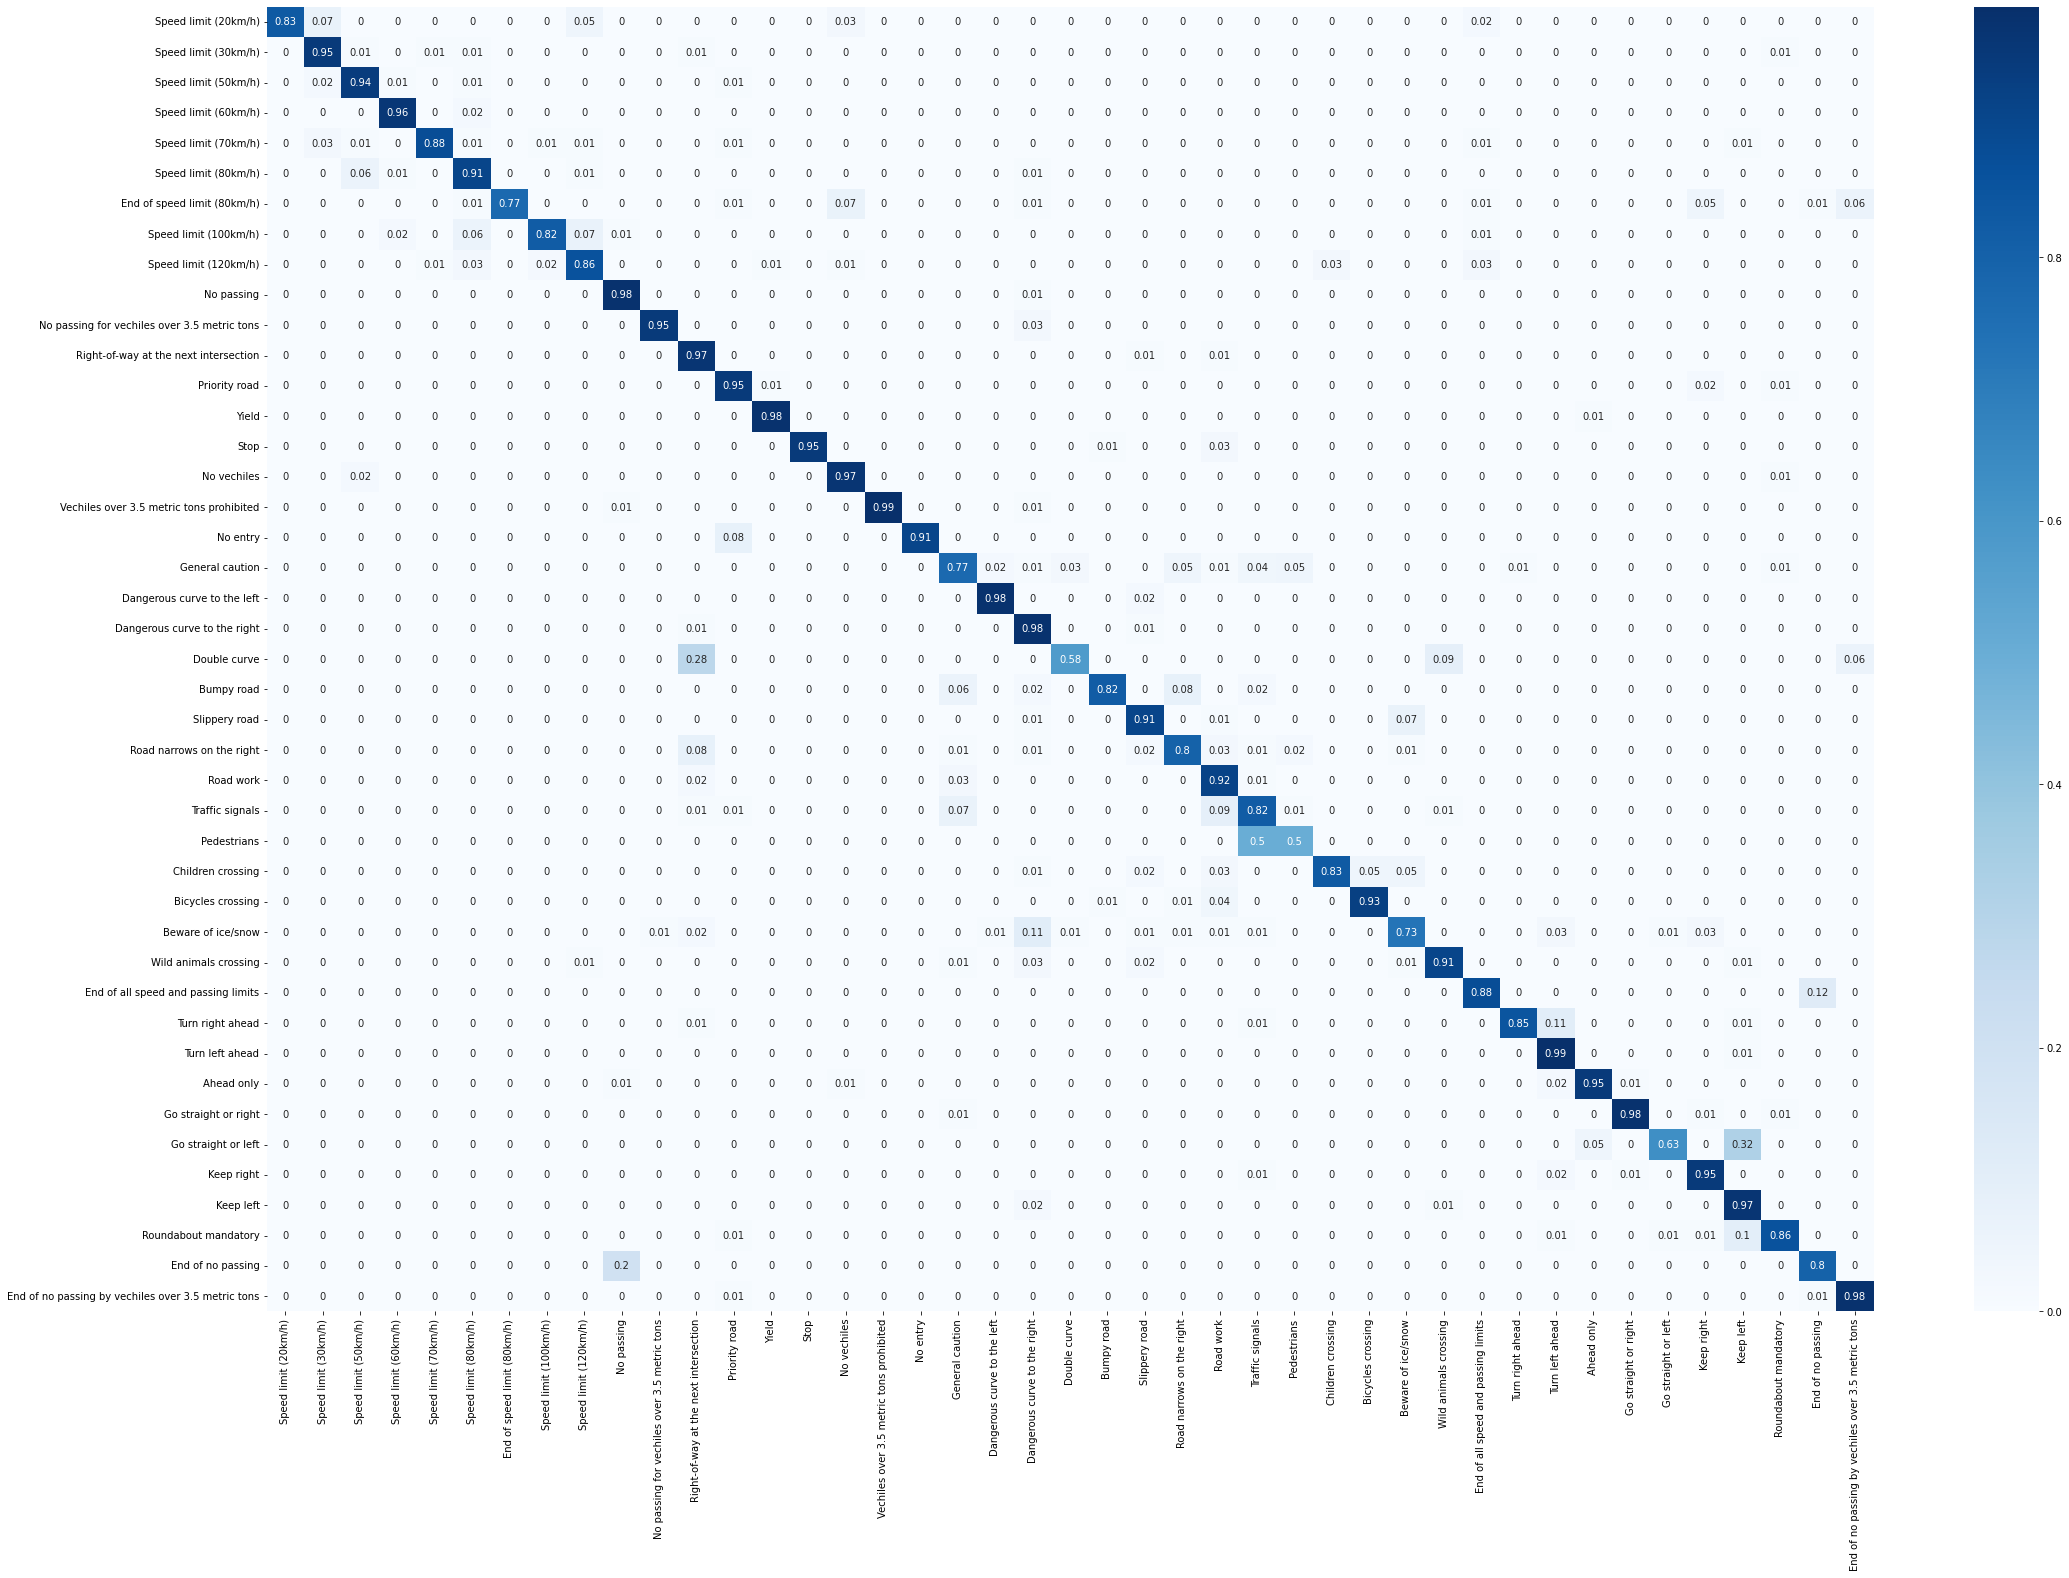

In [23]:
predictions = []
with torch.no_grad():
    for inputs, _ in test_dl: 
        predictions.extend(torch.argmax(lenet(inputs), dim=1).data.cpu().numpy())

cf_matrix = confusion_matrix(test_dataset.labels, predictions)

df_cm = pd.DataFrame(
    data = [row / np.sum(row) for row in cf_matrix],
    index = [i for i in class_names], 
    columns = [i for i in class_names]
).round(2)

plt.figure(figsize = (36,24))
sn.heatmap(df_cm, annot=True, cmap="Blues")

Na osnovu dobijene matrice konfuzije dobili smo karakteristične greške za CNN, s obzirom da se ovaj model pokazao kao precizniji.

Usled činjenice da saobraćajni znakovi koji pripadaju istoj kategoriji imaju isti oblik i boje, najčešće dolazi do grešaka u takvim grupama znakova. Zbog toga greške se najčešće pojavljuju kod znakova opasnosti (karakteristični po crvenom trouglu usmerenom ka gore) i znakova zabrana (crveni krug).

Ono što je izuzetno važno jeste da su neki od "najvažnijih" znakova kao što su obavezno zaustavljanje (Stop), ukrštanje sa putem sa prvenstom prolaza (Yield), put sa prvenstvom prolaza (Priority road), skoro uvek ispravno prepoznati jer su njihovi oblici jedinstveni.

Greške nisu uvek iste, odstupanja postoje između ostalog zbog nasumične podele podataka na skup za trening i validaciju, kao i zbog izmešanih batch-ova za trening.

U jednom od izvršavanja, najznačajnije greške su bile sledeće:

- u 57% slučajeva znak za klizav put (Slippery Road) je protumačen kao znak za opasnu krivinu na levo (Dangerous curve to the left)
- u 50% slučajeva znak za pešake (Pedestrians) je protumačen kao znak za dvostruku krivinu (Double curve)
- u 32% slučajeva znak za kružni tok (Roundabout mandatory) je protumačen kao znak obavezan pravac napred ili levo (Go straight or left)
- u 22% slučajeva znak za ograničenje brzine na 20km/h (Speed limit 20km/h) je protumačen kao 120km/h (Speed limit 120km/h)
- u 20% slučajeva znak za prestanak zabrane preticanja (End of no passing) je protumačen kao pocetak iste zabrane (No passing)